# Fault Free Analog Computing
* Assume we have 3 layers (1+2 compensate layer)
* This part of the simchip's program variation is only for demonstrating the use of our code (its program variation may not be consistent with actual chips).
* In our paper, all the data for multilayer is obtained from experiments and is unrelated to this example.

Author: Zhicheng Xu, Contact: xuzc2001@connect.hku.hk

## Generate the simulation chip

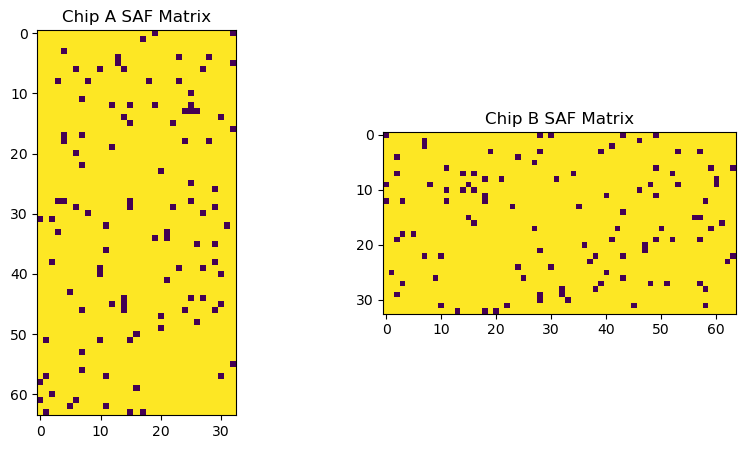

In [1]:
from SimChip import *
import matplotlib.pyplot as plt
# generate the simulation chip with 64x33 and 33x64
SA0_rate = 0.05
chipA0 = SimChip(64,33,SA0_rate)
chipB0 = SimChip(33,64,SA0_rate)
SAFinfo_A0 = chipA0.mask_matrix
SAFinfo_B0 = chipB0.mask_matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(SAFinfo_A0.T)
ax1.set_title('Chip A SAF Matrix')
ax2.imshow(SAFinfo_B0.T)
ax2.set_title('Chip B SAF Matrix')
plt.show()
chipA1 = SimChip(64,33,SA0_rate)
chipB1 = SimChip(33,64,SA0_rate)
SAFinfo_A1 = chipA1.mask_matrix
SAFinfo_B1 = chipB1.mask_matrix
chipA2 = SimChip(64,33,SA0_rate)
chipB2 = SimChip(33,64,SA0_rate)
SAFinfo_A2 = chipA2.mask_matrix
SAFinfo_B2 = chipB2.mask_matrix

# Select the Target Matrix

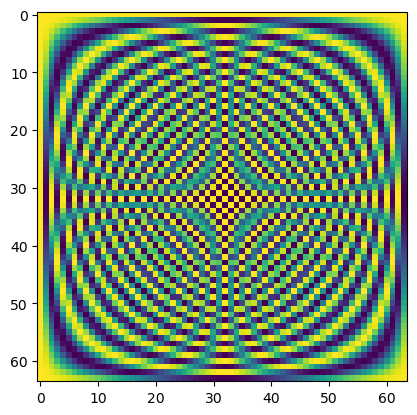

In [2]:
# Generate the real part of the 64-point DFT matrix (using a library)
dft_matrix = torch.fft.fft(torch.eye(64))
dft_matrix_real = torch.real(dft_matrix)
plt.imshow(dft_matrix_real)
plt.show()


# Using the model to optimize the submatrix

In [3]:
from FFAC import *
layer=[64,33,64]
# To get the best result, it is recommend to consider the stuck device at the first layer and the second layer at the same time
first_layer_model=MapAlg(dft_matrix_real,SAFinfo_A0*SAFinfo_A1,SAFinfo_B0*SAFinfo_B1,layer=layer,device='cuda:0')

self.fc1 shape: torch.Size([33, 64])
self.fc2 shape: torch.Size([64, 33])


In [4]:
lr=1e-4
for i in range(20):
    epochs=1000
    print("epochs:",epochs*(i+1),"loss:",first_layer_model.fit_cos(epochs,lr,bestmode="off",resetflag=False,visual=False))


epochs: 1000 loss: 0.0691207680888587
epochs: 2000 loss: 0.0006608670855916543
epochs: 3000 loss: 1.2162267055915166e-05
epochs: 4000 loss: 3.136623448307674e-06
epochs: 5000 loss: 3.402838230082139e-07
epochs: 6000 loss: 1.2766740276060062e-07
epochs: 7000 loss: 2.1342815403890825e-08
epochs: 8000 loss: 8.736308454437847e-09
epochs: 9000 loss: 2.2405698940630714e-07
epochs: 10000 loss: 4.9781290201167394e-11
epochs: 11000 loss: 7.867567797248398e-08
epochs: 12000 loss: 3.714539786869864e-11
epochs: 13000 loss: 3.796729597382864e-11
epochs: 14000 loss: 3.9240721783073695e-11
epochs: 15000 loss: 1.3392842390658188e-11
epochs: 16000 loss: 5.247788724682678e-07
epochs: 17000 loss: 3.0534241801660755e-11
epochs: 18000 loss: 2.509074609191586e-07
epochs: 19000 loss: 3.508460189038942e-11
epochs: 20000 loss: 2.708992381861286e-06


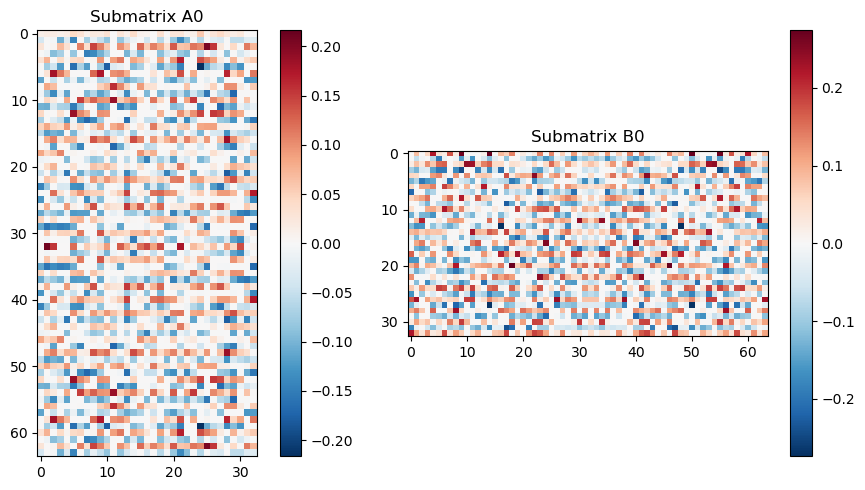

In [5]:
#

submatrixA0,submatrixB0=first_layer_model.weight_to_supert()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.cm.RdBu_r  # 使用RdBu_r色图：红色为正值，蓝色为负值

# 显示子矩阵A
max_val_A = np.max(np.abs(submatrixA0.cpu().numpy()))
cax1 = ax1.imshow(submatrixA0.cpu().numpy().T, cmap=cmap, vmin=-max_val_A, vmax=max_val_A)
ax1.set_title('Submatrix A0')
fig.colorbar(cax1, ax=ax1)

# 显示子矩阵B
max_val_B = np.max(np.abs(submatrixB0.cpu().numpy()))
cax2 = ax2.imshow(submatrixB0.cpu().numpy().T, cmap=cmap, vmin=-max_val_B, vmax=max_val_B)
ax2.set_title('Submatrix B0')
fig.colorbar(cax2, ax=ax2)

plt.tight_layout()
plt.show()


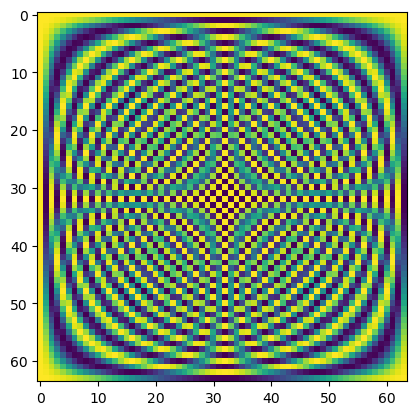

In [6]:
plt.imshow(np.dot(submatrixA0.cpu().numpy().T,submatrixB0.cpu().numpy().T))


# Simulation program the submatrix to the Simchip
* get_Target is used for the compensate layer (not the final layer)

In [ ]:
def get_Target(submatrix):
    Temp = submatrix.to('cpu')
    # Normalize
    normalized = Temp * 150e-6 / torch.max(torch.abs(Temp))
    # Positive values subtract 15e-6, negative values add 15e-6
    Target = torch.zeros_like(normalized)
    # Handle positive values
    mask_pos = normalized > 0
    Target[mask_pos] = normalized[mask_pos] - 15e-6
    # If positive values become negative after subtracting 15e-6, set to 0
    Target[(Target < 0) & mask_pos] = 0
    # Handle negative values
    mask_neg = normalized < 0
    Target[mask_neg] = normalized[mask_neg] + 15e-6
    # If negative values become positive after adding 15e-6, set to 0
    Target[(Target > 0) & mask_neg] = 0
    return Target

Target_A0 = get_Target(submatrixA0)
Target_B0 = get_Target(submatrixB0)
chipA0.get_target_value(Target_A0)
chipB0.get_target_value(Target_B0)
# Simulate programming the submatrix to the Simchip
# assume the variation rate is 2% (2uS)
variation_rate = 0.02
chipA0.sim_program(variation_rate)
chipB0.sim_program(variation_rate)


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -8.3214e-05,  1.0098e-04],
        [ 3.1599e-05, -1.9367e-05,  2.7050e-05,  ...,  4.3684e-05,
          0.0000e+00,  4.1816e-05],
        [ 0.0000e+00,  0.0000e+00,  1.9840e-06,  ...,  1.6040e-05,
          0.0000e+00,  3.5320e-06],
        ...,
        [ 1.7753e-05,  0.0000e+00,  5.6825e-05,  ...,  2.7889e-05,
         -1.4515e-05,  5.3131e-05],
        [ 0.0000e+00,  0.0000e+00,  3.0068e-06,  ...,  1.3265e-05,
          0.0000e+00,  2.9656e-06],
        [ 2.8493e-05, -1.8339e-05,  2.9134e-05,  ...,  4.5709e-05,
          0.0000e+00,  4.0982e-05]], dtype=torch.float64)

## show simulate program result
* The stuck device at the first layer was marked as 'X'

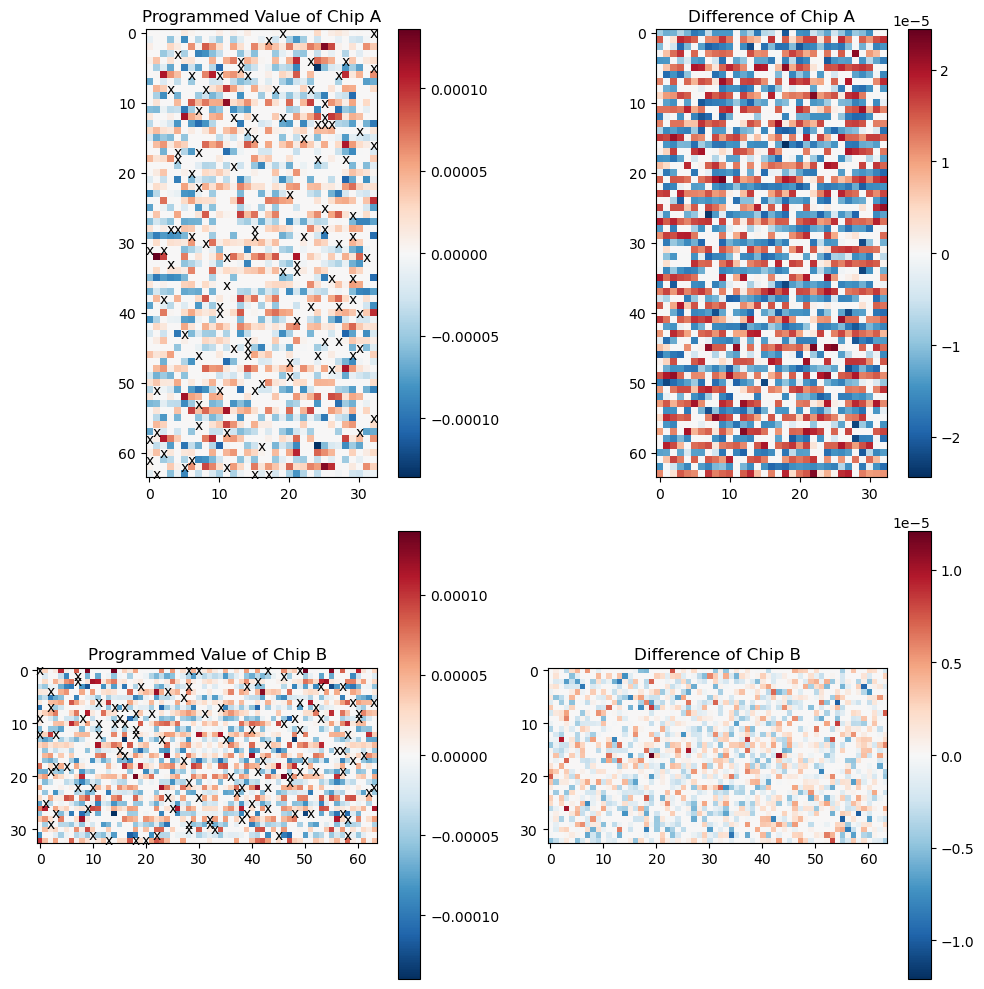

In [8]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cmap = plt.cm.RdBu_r  # Use RdBu_r colormap: red for positive values, blue for negative values

# Display programmed values of chip A
max_val_A = np.max(np.abs(chipA0.programmed_value.numpy()))
im1 = axes[0, 0].imshow(chipA0.programmed_value.numpy().T, cmap=cmap, vmin=-max_val_A, vmax=max_val_A)
axes[0, 0].set_title('Programmed Value of Chip A')
fig.colorbar(im1, ax=axes[0, 0])

# Mark 'x' at positions where the mask is 0
mask_A = chipA0.mask_matrix.numpy().T
rows_A, cols_A = np.where(mask_A == 0)
for i, j in zip(rows_A, cols_A):
    axes[0, 0].text(j, i, 'x', ha='center', va='center', color='black')

# Display the difference of chip A (programmed value - target value)
#diff_A = chipA0.programmed_value - chipA0.target_value
diff_A=chipA0.programmed_value-submatrixA0.cpu()*150e-6/submatrixA0.abs().max().cpu()
max_diff_A = np.max(np.abs(diff_A.numpy()))
im2 = axes[0, 1].imshow(diff_A.numpy().T, cmap=cmap, vmin=-max_diff_A, vmax=max_diff_A)
axes[0, 1].set_title('Difference of Chip A')
fig.colorbar(im2, ax=axes[0, 1])

# Display programmed values of chip B
max_val_B = np.max(np.abs(chipB0.programmed_value.numpy()))
im3 = axes[1, 0].imshow(chipB0.programmed_value.numpy().T, cmap=cmap, vmin=-max_val_B, vmax=max_val_B)
axes[1, 0].set_title('Programmed Value of Chip B')
fig.colorbar(im3, ax=axes[1, 0])

# Mark 'x' at positions where the mask is 0
mask_B = chipB0.mask_matrix.numpy().T
rows_B, cols_B = np.where(mask_B == 0)
for i, j in zip(rows_B, cols_B):
    axes[1, 0].text(j, i, 'x', ha='center', va='center', color='black')

# Display the difference of chip B (programmed value - target value)
diff_B = chipB0.programmed_value - chipB0.target_value
max_diff_B = np.max(np.abs(diff_B.numpy()))
im4 = axes[1, 1].imshow(diff_B.numpy().T, cmap=cmap, vmin=-max_diff_B, vmax=max_diff_B)
axes[1, 1].set_title('Difference of Chip B')
fig.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# simulation inference

torch.Size([33, 64])


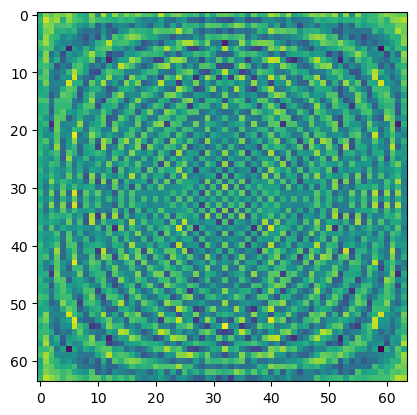

tensor(0.8125, dtype=torch.float64)


In [9]:
temp=chipA0.sim_inference(torch.eye(64).double())
#temp = torch.matmul(chipA.programmed_value, torch.eye(64).double())
print(temp.shape)
#result=chipB.sim_inference(temp)
result = torch.matmul(chipB0.programmed_value, temp)
#result= torch.matmul(Target_A.T,Target_B.T)
plt.imshow(result.cpu().numpy())
plt.show()

cos_result = torch.nn.functional.cosine_similarity(result.flatten(), dft_matrix_real.flatten(), dim=0)
print(cos_result)


# First compensate layer (Second layer)

In [10]:
first_layer = first_layer_model.output_nn()
rescaleA0=submatrixA0.cpu().abs().max()/150e-6
rescaleB0=submatrixB0.cpu().abs().max()/150e-6
first_layer.SuperT_update(chipA0.programmed_value.to('cuda:0')*rescaleA0, chipB0.programmed_value.to('cuda:0')*rescaleB0)
compensate_layer_model = MapAlg(dft_matrix_real.to('cuda:0'), chipA1.mask_matrix.to('cuda:0'), chipB1.mask_matrix.to('cuda:0'), layer=layer, device='cuda:0', FatherNN=first_layer, aslice_scale=0.20)

# plt.imshow((diff_A-chipA1.mask_matrix*diff_A))
# plt.show()
#计算diff_a 和 compensate_layer.fc1.weight.data 的cosine similarity
#cos_result=torch.nn.functional.cosine_similarity(-diff_A.flatten(), compensate_layer.fc1.weight.data.cpu().flatten(), dim=0)





self.fc1 shape: torch.Size([33, 64])
self.fc2 shape: torch.Size([64, 33])


In [11]:

lr=1e-4
for i in range(10):
    epochs=2000
    print("epochs:",epochs*(i+1),"loss:",compensate_layer_model.fit_cos(epochs,lr,bestmode="saf",resetflag=False,visual=False))


The best loss: 1.001454341675867e-07
epochs: 2000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 4000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 6000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 8000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 10000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 12000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 14000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 16000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 18000 loss: 1.017440189876595e-07
The best loss: 1.001454341675867e-07
epochs: 20000 loss: 1.017440189876595e-07


tensor(0.2092, device='cuda:0', dtype=torch.float64)
tensor(0.0352, device='cuda:0', dtype=torch.float64)


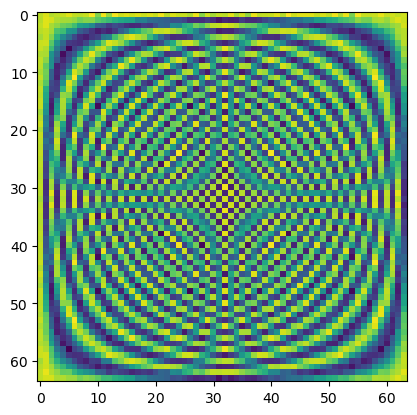

tensor(0.9927, dtype=torch.float64)


In [25]:
submatrixA1,submatrixB1=compensate_layer_model.weight_to_supert()
print(submatrixA0.max())
print(submatrixA1.max())
scaleA01=(submatrixA1.abs().max()/submatrixA0.abs().max()).cpu()
scaleB01=(submatrixB1.abs().max()/submatrixB0.abs().max()).cpu()
Target_A1 = get_Target(submatrixA1)
Target_B1 = get_Target(submatrixB1)

chipA1.get_target_value(Target_A1)
chipB1.get_target_value(Target_B1)
# Simulate programming the submatrix to the Simchip
variation_rate = 0.02 #0.02*150uS=3uS
chipA1.sim_program(variation_rate)
chipB1.sim_program(variation_rate)

temp0=chipA0.sim_inference(torch.eye(64).double())
temp1=chipA1.sim_inference(torch.eye(64).double())
temp=temp0+temp1*scaleA01    
result0=chipB0.sim_inference(temp)
result1=chipB1.sim_inference(temp)
result=result0+result1*scaleB01
plt.imshow(result.cpu().numpy())
plt.show()

cos_result = torch.nn.functional.cosine_similarity(result.flatten(), dft_matrix_real.flatten(), dim=0)
print(cos_result)


# Final layer

In [27]:
compensate_layer1 = compensate_layer_model.output_nn()
rescaleA1=submatrixA1.cpu().abs().max()/150e-6
rescaleB1=submatrixB1.cpu().abs().max()/150e-6
compensate_layer1.SuperT_update(chipA1.programmed_value.to('cuda:0')*rescaleA1, chipB1.programmed_value.to('cuda:0')*rescaleB1)
final_layer_model=MapAlg(dft_matrix_real.to('cuda:0'), chipA2.mask_matrix.to('cuda:0'), chipB2.mask_matrix.to('cuda:0'), layer=layer, device='cuda:0', FatherNN=compensate_layer1, aslice_scale=0.20)


self.fc1 shape: torch.Size([33, 64])
self.fc2 shape: torch.Size([64, 33])


In [28]:
lr=1e-4
for i in range(10):
    epochs=20
    print("epochs:",epochs*(i+1),"loss:",final_layer_model.fit_cos(epochs,lr,bestmode="saf",resetflag=False,visual=False))




The best loss: 0.0004441497238646397
epochs: 20 loss: 0.00043695743702854006
The best loss: 0.0003567922180045535
epochs: 40 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 60 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 80 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 100 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 120 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 140 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 160 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 180 loss: 0.0003630530082392447
The best loss: 0.0003567922180045535
epochs: 200 loss: 0.0003630530082392447


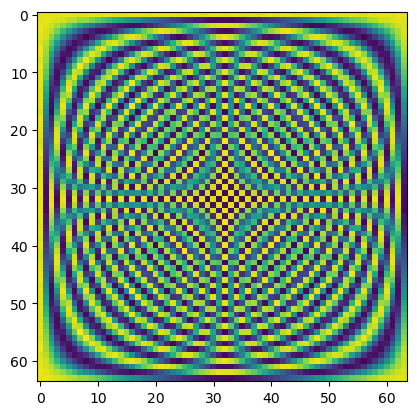

tensor(0.9996, dtype=torch.float64)


In [30]:
submatrixA2,submatrixB2=final_layer_model.weight_to_supert()
Target_A2 = submatrixA2*150e-6/submatrixA2.abs().max()
Target_B2 = submatrixB2*150e-6/submatrixB2.abs().max()
scaleA02=(submatrixA2.abs().max()/submatrixA0.abs().max()).cpu()
scaleB02=(submatrixB2.abs().max()/submatrixB0.abs().max()).cpu()
chipA2.get_target_value(Target_A2.cpu())
chipB2.get_target_value(Target_B2.cpu())
# Simulate programming the submatrix to the Simchip
variation_rate = 0 #0.02*150uS=3uS
chipA2.sim_program(variation_rate)
chipB2.sim_program(variation_rate)

temp0=chipA0.sim_inference(torch.eye(64).double())
temp1=chipA1.sim_inference(torch.eye(64).double())
temp2=chipA2.sim_inference(torch.eye(64).double())
temp=temp0+temp1*scaleA01+temp2*scaleA02

result0=chipB0.sim_inference(temp)
result1=chipB1.sim_inference(temp)
result2=chipB2.sim_inference(temp)
result=result0+result1*scaleB01+result2*scaleB02
plt.imshow(result.cpu().numpy())
plt.show()

cos_result = torch.nn.functional.cosine_similarity(result.flatten(), dft_matrix_real.flatten(), dim=0)
print(cos_result)
